In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_log_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import classification_report
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import time

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd '/content/drive/MyDrive/Colab Notebooks/5 семестр. Машинное обучение/data'

/content/drive/MyDrive/Colab Notebooks/5 семестр. Машинное обучение/data


In [4]:
hearts_df = pd.read_csv('heart.csv', encoding = 'utf-8', sep = ',')
hearts_df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [5]:
X = hearts_df[hearts_df.columns[:-1]]
Y = hearts_df['HeartDisease']

X = pd.get_dummies(X, columns = ['Sex', 'ChestPainType', 'RestingECG', 'ST_Slope'])
X['ExerciseAngina'] = X['ExerciseAngina'].apply(lambda x: 0 if x == 'N' else 1)

Y.head()

0    0
1    1
2    0
3    1
4    0
Name: HeartDisease, dtype: int64

In [6]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = False)

In [7]:
clf = LogisticRegression(max_iter = 1000)
clf.fit(x_train, y_train)

LogisticRegression(max_iter=1000)

In [8]:
from sklearn import metrics

pred_train = clf.predict(x_train)
pred_test = clf.predict(x_test)

print('Точность обучения обучающей выборки', metrics.accuracy_score(y_train, pred_train))
print('Точность обучения тестовой выборки', metrics.accuracy_score(y_test, pred_test))

Точность обучения обучающей выборки 0.8814713896457765
Точность обучения тестовой выборки 0.8260869565217391


Модель переобучилась

# Что предсказываем

In [9]:
df_differences = pd.DataFrame(columns = ['Тип модели классификации', 
                                         'Accuracy_score', 
                                         'Precision_score', 
                                         'Recall_score', 
                                         'F1_score',
                                         'roc_auc'])

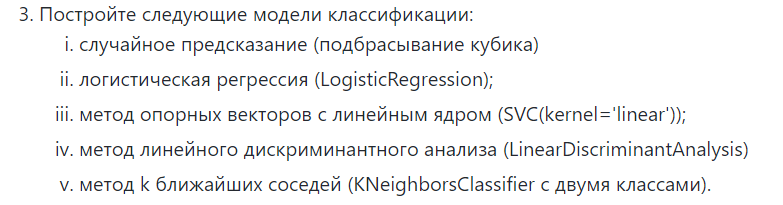

In [10]:
def plot_learning_curve(estimator, title, X, y, ax):
    """
         Draw the learning curve of data on a model.
         Parameter explanation
    ----------
         estimator: The classifier you use.
         title: The title of the table.
         X: input feature, numpy type
         y: input target vector
         ylim: (ymin, ymax) in tuple format, set the lowest point and highest point of the ordinate in the image
         cv: When doing cross-validation, the data is divided into the number of copies, one of which is used as the cv set, and the remaining n-1 copies are used as training (default is 3 copies)
         n_jobs: the number of parallel tasks (default 1)
    """

    y_pred = estimator.predict(X)
    y_pred_proba = estimator.predict_proba(X)
    probs = y_pred_proba[:, 1]
    fpr, tpr, treshold = metrics.roc_curve(y, probs)
    roc_auc = metrics.auc(fpr, tpr)
    plt.plot(fpr, tpr)

    return roc_auc

In [11]:
import warnings
warnings.filterwarnings("ignore")

3.0994415283203125e-06 seconds время обучения модели Случайное предсказание
0.8654232025146484 seconds время обучения модели Логистическая регрессия
17.79158592224121 seconds время обучения модели Метод опорных векторов с линейным ядром (SVC)
0.02960681915283203 seconds время обучения модели Линейный дискриминантный анализ
0.019392967224121094 seconds время обучения модели К ближайших соседей


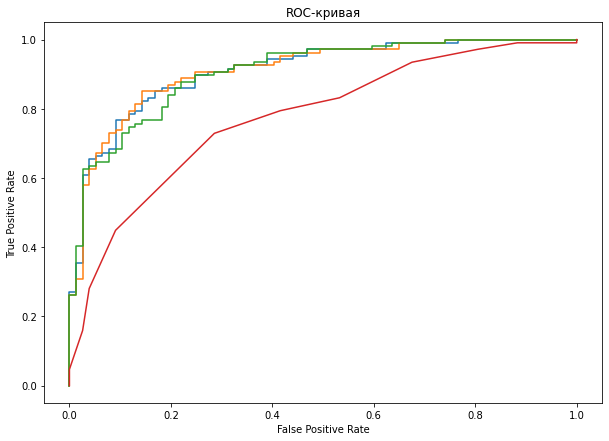

In [12]:
# Определяем методы

def RandomPrediction():
  result = np.random.randint(2, size = len(x_test))
  return result

learning_models = {
    "Случайное предсказание": RandomPrediction(),
    "Логистическая регрессия": LogisticRegression(max_iter = 1000),
    "Метод опорных векторов с линейным ядром (SVC)": svm.SVC(kernel = 'linear', probability = True),
    "Линейный дискриминантный анализ": LinearDiscriminantAnalysis(),
    "К ближайших соседей": KNeighborsClassifier(n_neighbors = int(np.sqrt(len(x_test)))),
    
}

y_test_predict = dict()
i = 0
fig, ax = plt.subplots(figsize = (10, 7))
for name, model in learning_models.items():
    start_time = time.time()
    if name == 'Случайное предсказание':
      y_test_predict[name] = model
    else:
      model.fit(x_train, y_train)
      y_test_predict[name] = model.predict(x_test)
    print(f"{(time.time() - start_time)} seconds время обучения модели {name}")

    # Строим кривые обучения для каждой модели

    if name != "Случайное предсказание":
        train_sizes, train_scores, test_scores = learning_curve(model, x_train, y_train, train_sizes = [3, 6, 10], cv = 3)
        
        roc_auc = plot_learning_curve(model, name, x_test, y_test, ax)                 
    else:
      roc_auc = 0.500
      
    df_differences.loc[i] = [name,
                         accuracy_score(y_test, y_test_predict[name]),
                         precision_score(y_test, y_test_predict[name], average = 'macro'),
                         recall_score(y_test, y_test_predict[name], average = 'macro'),
                         f1_score(y_test, y_test_predict[name], average = 'macro'),
                         roc_auc]
    i += 1   
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()             

**4. Проанализируйте метрики каждой модели и сделайте выводы об их эффективности и применимости. Сравните эффективность всех этих моделей и выберите лучшую;**

In [13]:
df_differences

,Тип модели классификации,Accuracy_score,Precision_score,Recall_score,F1_score,roc_auc
0,Случайное предсказание,0.494565,0.505288,0.505340,0.494431,0.500000
1,Логистическая регрессия,0.826087,0.828167,0.812234,0.817460,0.910669
2,Метод опорных векторов с линейным ядром (SVC),0.842391,0.844574,0.829894,0.834978,0.911640
3,Линейный дискриминантный анализ,0.826087,0.824380,0.815876,0.819165,0.906421
4,К ближайших соседей,0.722826,0.717381,0.721629,0.718427,0.775337
